# Imports

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from sklearn.neural_network import MLPClassifier
import hygeia.utils.preprocessing_tools as pt
import local_tools as lt

# Read ORiginal data

In [4]:
adata_template = sc.read_h5ad(
    '/data/Experiments/Benchmark/SCDISENTANGLE_REPRODUCE/Datasets/preprocessed_datasets/prostate.h5ad'
)

# Normalize

In [ ]:
sc.pp.normalize_total(
    adata_template, 
    target_sum=1e4
)
sc.pp.log1p(adata_template)

In [2]:
time_oods = [
    'T02_Cast_Day7', 'T03_Cast_Day14', \
    'T04_Cast_Day28', 'T05_Regen_Day1', 'T06_Regen_Day2',\
    'T07_Regen_Day3', 'T08_Regen_Day7', 'T09_Regen_Day14', 'T10_Regen_Day28'
]

In [ ]:
adata_pred_cat = None
adata_gt_cat = None

for time_ood in time_oods:
    # Load data
    
    adata_pred = sc.read_h5ad(f'predictions/{time_ood}.h5ad')
    adata_gt = sc.read_h5ad(f'ground_truth/{time_ood}.h5ad')
   
    adata_pred = adata_pred[adata_pred.obs['time_pred'] == time_ood].copy()
    adata_pred = adata_pred[adata_pred.obs['predType'] == 'Epi_Luminal_2Psca'].copy()
    adata_pred.obs['time'] = time_ood
    
    adata_gt = adata_gt[adata_gt.obs['time'] == time_ood].copy()
    adata_gt = adata_gt[adata_gt.obs['predType'] == 'Epi_Luminal_2Psca'].copy()
    
    if adata_pred_cat is None:
        adata_pred_cat = adata_pred.copy()
        adata_gt_cat = adata_gt.copy()
    else:
        adata_pred_cat = adata_pred_cat.concatenate(adata_pred)
        adata_gt_cat = adata_gt_cat.concatenate(adata_gt)

In [5]:
adata_pred_cat.var_names = adata_template.var_names.copy()
adata_gt_cat.var_names = adata_template.var_names.copy()

In [6]:
import phate
phate_op = phate.PHATE()
adata_gt_cat.obsm['X_phate'] = phate_op.fit_transform(adata_gt_cat.X)
adata_pred_cat.obsm['X_phate'] = phate_op.transform(adata_pred_cat.X)

Calculating PHATE...
  Running PHATE on 769 observations and 5027 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.91 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.98 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.31 seconds.
Calculated PHATE in 2.10 seconds.
Calculating KNN search...
Calculated KNN search in 0.06 seconds.
Calculating affinities...


/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [7]:
adata_pred_cat = lt.rename_time_points(adata_pred_cat,  mapping_type='full')
adata_gt_cat = lt.rename_time_points(adata_gt_cat, mapping_type='full')

In [8]:
subset_ctypes = ['Epi_Luminal_1', 'Epi_Luminal_2Psca']

[<Axes: title={'center': 'Pbsn'}, xlabel='X_phate1', ylabel='X_phate2'>,
 <Axes: title={'center': 'time_renamed'}, xlabel='X_phate1', ylabel='X_phate2'>]

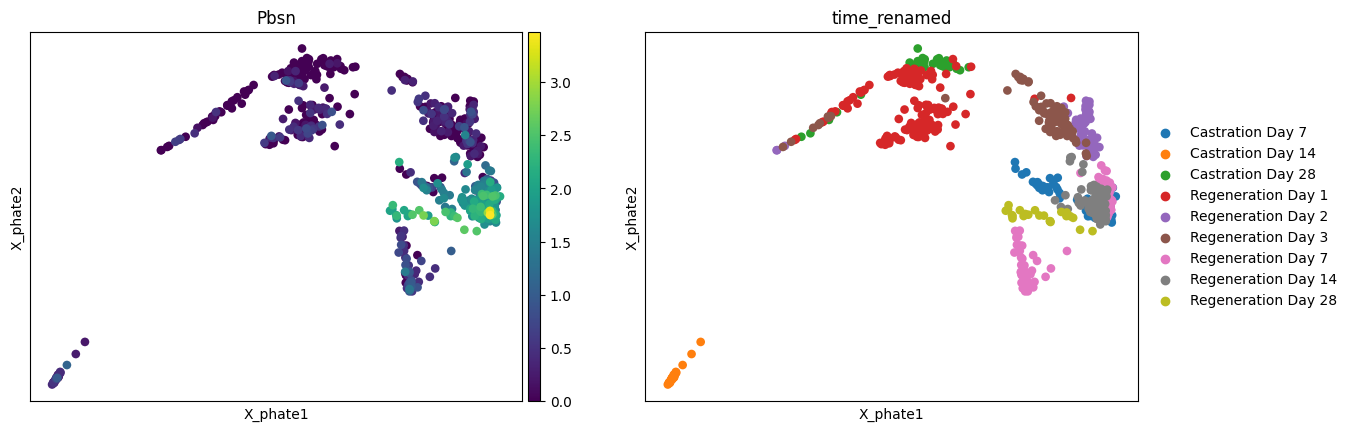

In [10]:
sc.pl.embedding(
    adata_gt_cat, 
    basis='X_phate', 
    color=['Pbsn', 'time_renamed'], 
    show=False
)

[<Axes: title={'center': 'Pbsn'}, xlabel='X_phate1', ylabel='X_phate2'>,
 <Axes: title={'center': 'time_renamed'}, xlabel='X_phate1', ylabel='X_phate2'>]

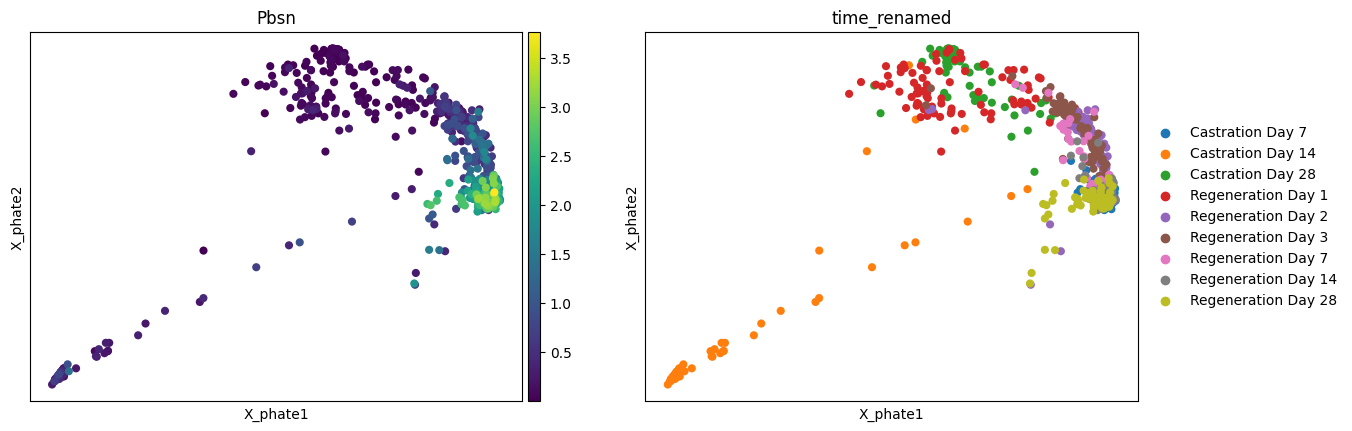

In [11]:
sc.pl.embedding(
    adata_pred_cat, 
    basis='X_phate', 
    color=['Pbsn', 'time_renamed'], 
    show=False
)

In [ ]:
adata_gt_subset = adata_gt_cat[adata_gt_cat.obs['predType'] == 'Epi_Luminal_2Psca']
adata_pred_subset = adata_pred_cat[adata_pred_cat.obs['predType'] == 'Epi_Luminal_2Psca']

In [ ]:
import phate
phate_op = phate.PHATE()
adata_gt_subset.obsm['X_phate'] = phate_op.fit_transform(adata_gt_subset.X)
adata_pred_subset.obsm['X_phate'] = phate_op.transform(adata_pred_subset.X)

In [ ]:
import os
save_path = '/data/scDisentangle figures/Prostate/Markers/'
os.makedirs(save_path, exist_ok=True)

In [ ]:
for gene_name in ['Pbsn', 'Tgm4', 'Krt18']:
    sc.pl.embedding(adata_gt_subset, basis='X_phate', color=[gene_name, 'time_renamed'], show=False)
    plt.savefig(f'{save_path}/{gene_name}_gt.png', dpi=400)
    plt.savefig(f'{save_path}/{gene_name}_gt.pdf', dpi=400)

    sc.pl.embedding(adata_pred_subset, basis='X_phate', color=[gene_name, 'time_renamed'], show=False) # Fcgbpl1
    plt.savefig(f'{save_path}/{gene_name}_pred.png', dpi=400)
    plt.savefig(f'{save_path}/{gene_name}_pred.pdf', dpi=400)

In [ ]:
# Pbsn, Tgm4, Krt 18, Gjc1 (downreg)